# Street Trees

This is a DeepForest demo using the Portland Street Trees dataset. Thank you to Portland Maps for street tree data (http://gis-pdx.opendata.arcgis.com/datasets/street-trees) and Oregon OSIP (https://www.oregon.gov/geo/Pages/imagery_status.aspx) for imagery.

The goal of this script is to test the ability of DeepForest to predict the location of street trees in 0.35m imagery using 1) prebuilt model, 2) a model trained on local data.

In [13]:
#Load packages
import numpy as np
from PIL import Image
import os
from matplotlib import pyplot as plt
%matplotlib inline

#Load deepforest
#Optional comet_ml for tracking experiments
from comet_ml import Experiment
from deepforest import deepforest
from deepforest import preprocess
from deepforest import utilities
from deepforest import __version__

This demo uses geospatial packages that are included in the DeepForest installation

In [14]:
#Geospatial packages
import shapely
import geopandas
import rasterio
import descartes

In [15]:
## Define geospatial function from https://gist.github.com/bw4sz/e2fff9c9df0ae26bd2bfa8953ec4a24c
#"project" into layer CRS to overlap with street trees. This isn't really a projection but a translation of the coordinate system
#Here is a simple utility function for reading in annotation files from .shp. This is not pre-installed in DeepForest since it relies on GDAL python packages, which can be tricky to prebuild for multiple operating systems and are only needed for this task. See http://geopandas.org/install.html.
def project(raster_path, boxes):
    """
    Convert image coordinates into a geospatial object to overlap with input image
    raster_path: path to the raster .tif on disk. Assumed to have a valid spatial projection
    boxes: a prediction pandas dataframe from deepforest.predict_tile()
    """
    with rasterio.open(raster_path) as dataset:
        bounds = dataset.bounds
        pixelSizeX, pixelSizeY  = dataset.res

    #subtract origin. Recall that numpy origin is top left! Not bottom left.
    boxes["left"] = (boxes["xmin"] *pixelSizeX) + bounds.left
    boxes["right"] = (boxes["xmax"] * pixelSizeX) + bounds.left
    boxes["top"] = bounds.top - (boxes["ymin"] * pixelSizeY) 
    boxes["bottom"] = bounds.top - (boxes["ymax"] * pixelSizeY)
    
    # combine column to a shapely Box() object, save shapefile
    boxes['geometry'] = boxes.apply(lambda x: shapely.geometry.box(x.left,x.bottom,x.right,x.top), axis=1)
    boxes = geopandas.GeoDataFrame(boxes, geometry='geometry')
    
    boxes.crs = "+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=399999.9999999999 +y_0=0 +ellps=GRS80 +units=ft +no_defs"

    return boxes

def shapefile_to_annotations(shapefile, rgb, savedir="."):
    """
    Convert a shapefile of annotations into annotations csv file for DeepForest training and evaluation
    Args:
        shapefile: Path to a shapefile on disk. If a label column is present, it will be used, else all labels are assumed to be "Tree"
        rgb: Path to the RGB image on disk
        savedir: Directory to save csv files
    Returns:
        None: a csv file is written
    """
    #Read shapefile
    gdf = geopandas.read_file(shapefile)

    #get coordinates
    df = gdf.geometry.bounds

    #raster bounds
    with rasterio.open(rgb) as src:
        left, bottom, right, top = src.bounds

    #Transform project coordinates to image coordinates
    df["tile_xmin"] = df.minx - left
    df["tile_xmin"] = df["tile_xmin"].astype(int)

    df["tile_xmax"] = df.maxx - left
    df["tile_xmax"] = df["tile_xmax"].astype(int)

    #UTM is given from the top, but origin of an image is top left

    df["tile_ymax"] = top - df.miny 
    df["tile_ymax"] = df["tile_ymax"].astype(int)

    df["tile_ymin"] = top - df.maxy
    df["tile_ymin"] = df["tile_ymin"].astype(int)    

    #Add labels is they exist
    if "label" in gdf.columns:
        df["label"] = gdf["label"]
    else:
        df["label"] = "Tree"

    #add filename
    df["image_path"] = os.path.basename(rgb)

    #select columns
    result = df[["image_path","tile_xmin","tile_ymin","tile_xmax","tile_ymax","label"]]
    result = result.rename(columns={"tile_xmin":"xmin","tile_ymin":"ymin","tile_xmax":"xmax","tile_ymax":"ymax"})
    
    #ensure no zero area polygons due to rounding to pixel size
    result = result[~(result.xmin == result.xmax)]
    result = result[~(result.ymin == result.ymax)]

    
    return result

Created a deepforest model and download latest release

In [16]:
prebuilt_model = deepforest.deepforest()
prebuilt_model.use_release()

Reading config file: /Users/ben/Documents/DeepForest_demos/env/lib/python3.7/site-packages/deepforest/data/deepforest_config.yml
A blank deepforest object created. To perform prediction, either train or load an existing model.
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/v0.2.1 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/v0.2.1
tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors


## Load test data

(2894, 2462, 3)


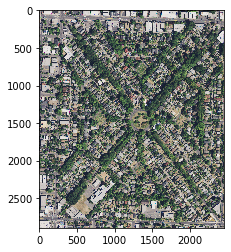

In [17]:
raster_path = "/Users/ben/Dropbox/Weecology/temp_training/street_trees_test.tif"
raster = Image.open(raster_path)
numpy_image = np.array(raster)
print(numpy_image.shape)

#drop alpha channel
numpy_image = numpy_image[:,:,:3]
plt.imshow(numpy_image)

## Notes on cross resolution training

This tile is almost 3000px wide, too large to be predicted in one attempt in memory. Instead we will divide the tile into overlapping windows to standardize prediction and better align with the training data from the prebuilt model. The prebuilt model was trained on 0.1m data, and this is 0.35m data. It not immediately obvious what size of overlapping windows best fits transfer learning across resolutions. Let's play with a couple window sizes to get a general visual impression.

### 200px Window

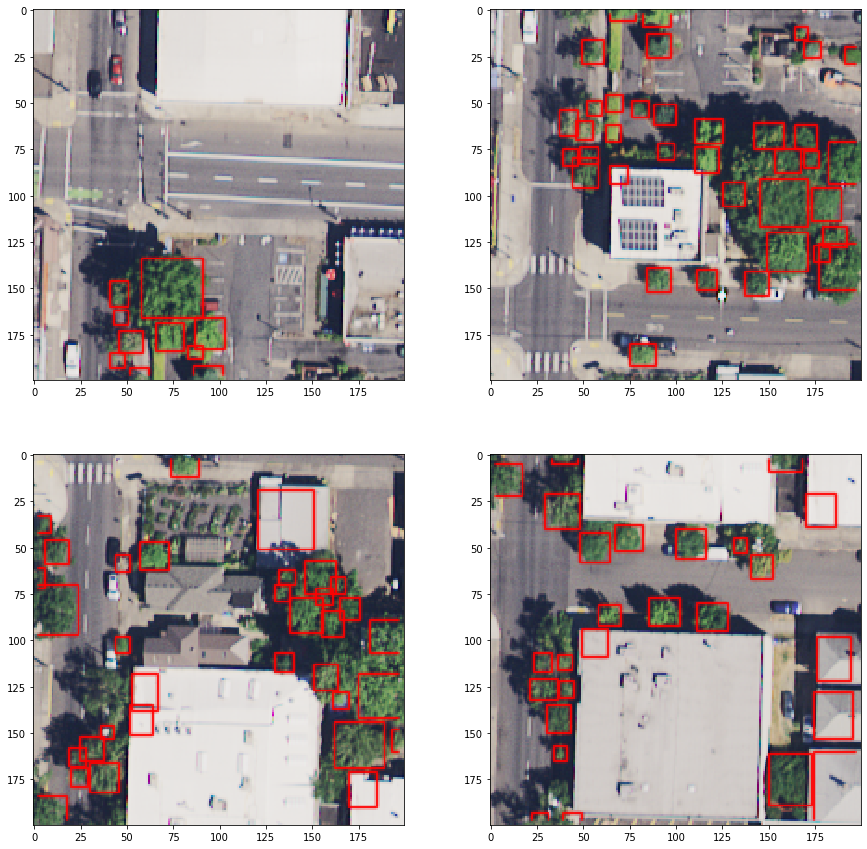

In [18]:
#Create windows of 400px
windows = preprocess.compute_windows(numpy_image, patch_size=200,patch_overlap=0.1)

#Loop through a few sample windows, crop and predict
fig, axes, = plt.subplots(nrows=2,ncols=2, figsize=(15,15))
axes = axes.flatten()
for index in range(4):
    crop = numpy_image[windows[index].indices()]
    #predict in bgr channel order, color predictions in red.
    prediction = prebuilt_model.predict_image(raw_image = crop[...,::-1],return_plot=True, color=(0,0,255), score_threshold=0.05)
    #but plot in rgb channel order
    axes[index].imshow(prediction[...,::-1])

### 400px Window

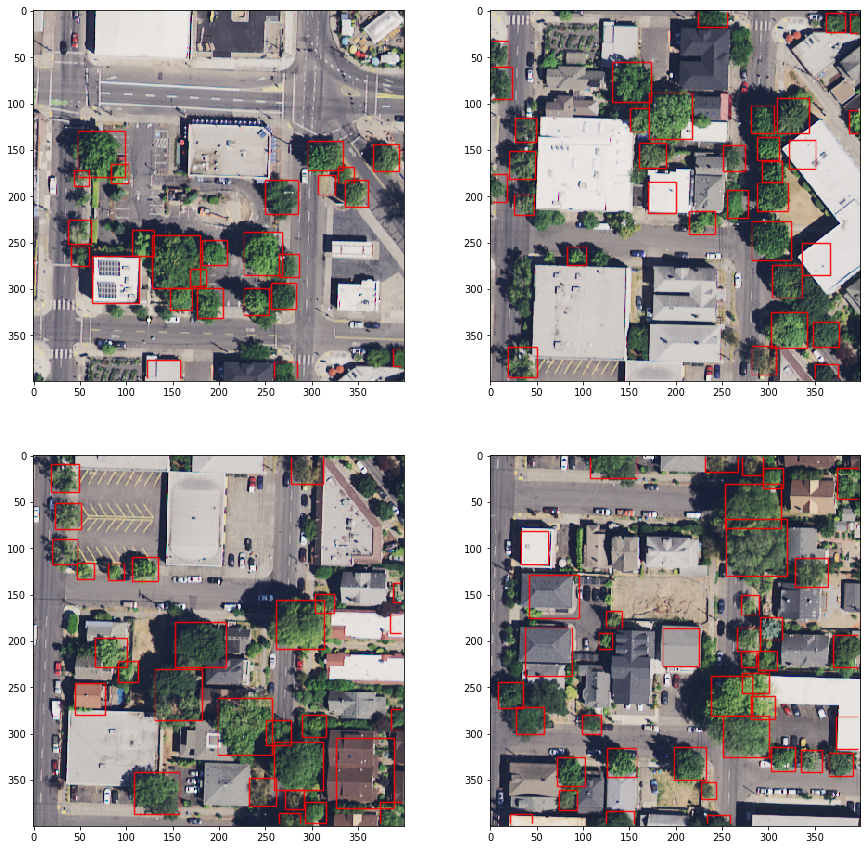

In [19]:
#Create windows of 400px
windows = preprocess.compute_windows(numpy_image, patch_size=400,patch_overlap=0.1)

#Loop through a few sample windows, crop and predict
fig, axes, = plt.subplots(nrows=2,ncols=2, figsize=(15,15))
axes = axes.flatten()
for index in range(4):
    crop = numpy_image[windows[index].indices()]
    #predict in bgr channel order, color predictions in red.
    prediction = prebuilt_model.predict_image(raw_image = crop[...,::-1],return_plot=True, color=(0,0,255), score_threshold=0.05)
    #but plot in rgb channel order
    axes[index].imshow(prediction[...,::-1])

That looks reasonable, clearly some buildings are being predicted, but that is not the fault of the window size

### 800px window

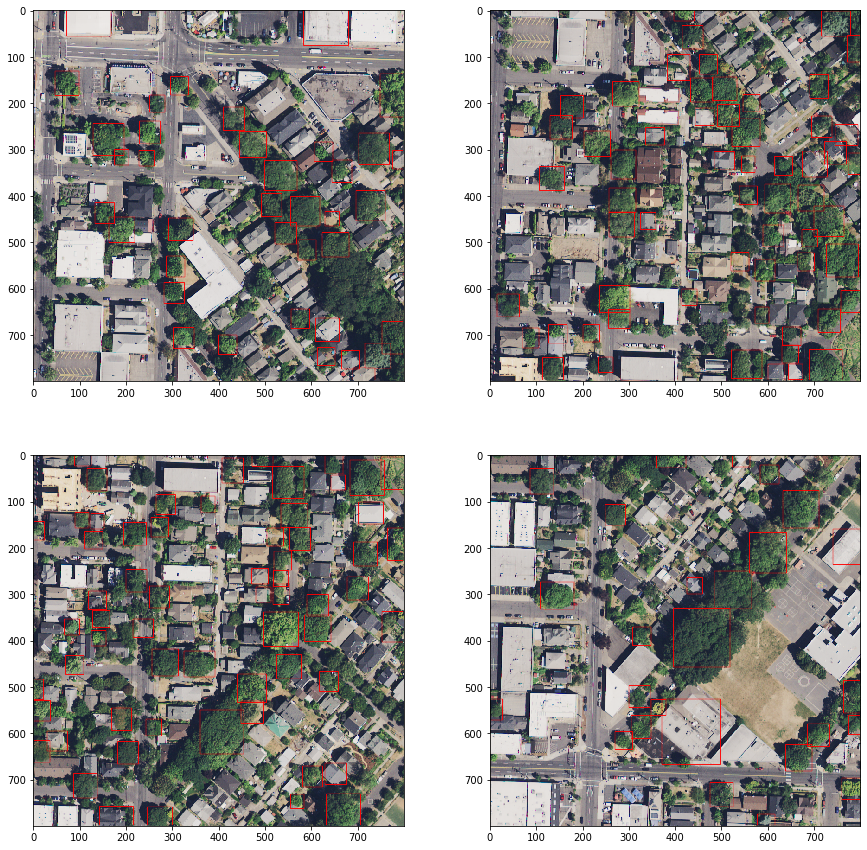

In [30]:
#Create windows of 800px
windows = preprocess.compute_windows(numpy_image, patch_size=800,patch_overlap=0.1)

#Loop through a few sample windows, crop and predict
fig, axes, = plt.subplots(nrows=2,ncols=2, figsize=(15,15))
axes = axes.flatten()
for index in range(4):
    crop = numpy_image[windows[index].indices()]
    #predict in bgr channel order, color predictions in red.
    prediction = prebuilt_model.predict_image(raw_image = crop[...,::-1],return_plot=True, color=(0,0,255), score_threshold=0.05)
    #but plot in rgb channel order
    axes[index].imshow(prediction[...,::-1])

From these intital results, it looks like sticking with windows of 400px is right size. 200 is better than expected, 800 feels like the small trees are being missed.

## Predict entire tile

DeepForest predict tile method is useful in automating the splitting of windows, prediction on each window, and recombining windows workflow

In [21]:
#TODO SET SCORE THRESHOLD
prebuilt_model.config["score_threshold"] = 0.05
prediction = prebuilt_model.predict_tile(raster_path, patch_size=400,patch_overlap=0.1)

2574 predictions in overlapping windows, applying non-max supression
2007 predictions kept after non-max suppression


In [25]:
prediction.head()
prediction.score

0       0.725649
1       0.715472
2       0.714275
3       0.712387
4       0.711431
          ...   
2002    0.200395
2003    0.200112
2004    0.200106
2005    0.200046
2006    0.200029
Name: score, Length: 2007, dtype: object

In [11]:
boxes = project(raster_path,prediction)
print(boxes.crs)
boxes.to_file("/Users/ben/Dropbox/Weecology/DeepForest/Oregon/prebuilt_model.shp",driver="ESRI Shapefile",crs_wkt=boxes.crs)

+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=399999.9999999999 +y_0=0 +ellps=GRS80 +units=ft +no_defs


# Overlay with street tree data

In [12]:
test_trees = geopandas.read_file("/Users/ben/Dropbox/Weecology/DeepForest/Oregon/test_trees.shp")
test_trees = test_trees[test_trees.geometry.is_valid]

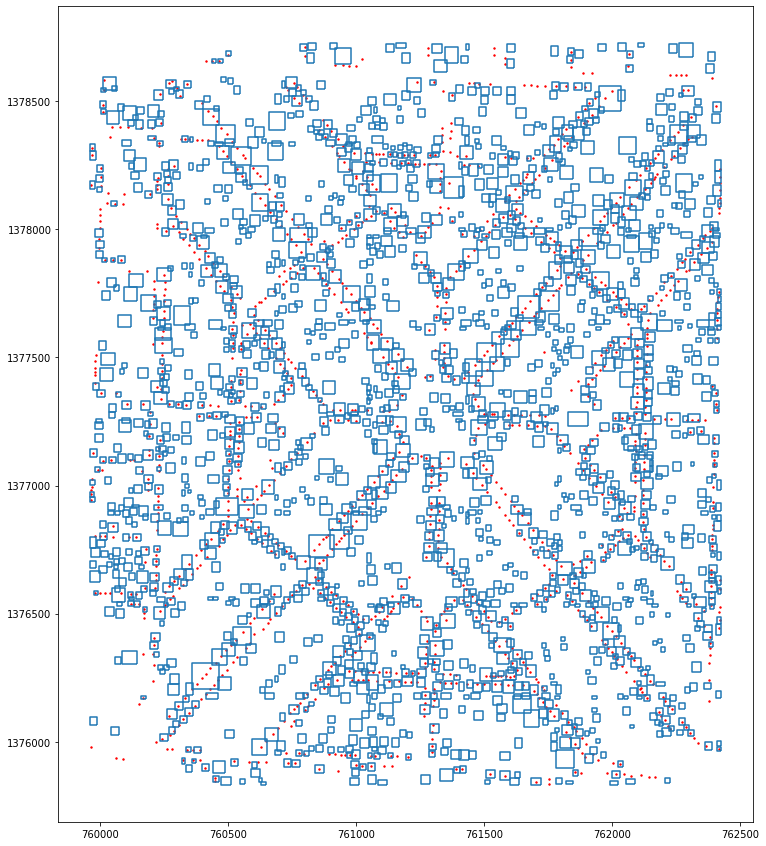

In [13]:
fig,ax = plt.subplots(figsize=(15,15))
boxes.boundary.plot(ax=ax)
test_trees.plot(ax=ax,color="red",markersize=2)

## What proportion of street trees are predicted?

In [14]:
print("Proportion of overlapping predictions: {}".format(sum(boxes.intersects(test_trees.unary_union))/test_trees.shape[0]))

# Could undersegmentations, the number of predictions that overlap with more than one tree
joined_df = geopandas.sjoin(boxes,test_trees)
counts = joined_df.index.value_counts()
print("Proportion of matches that contain more than one ground truth: {}".format(counts[counts>1].shape[0]/len(counts.index.unique())))

Proportion of overlapping predictions: 0.5424469413233458


/Users/ben/Documents/DeepForest_demos/env/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=399999.9999999999 +y_0=0 +ellps=GRS80 +units=ft +no_defs != {'proj': 'lcc', 'lat_1': 43, 'lat_2': 45.5, 'lat_0': 41.75, 'lon_0': -120.5, 'x_0': 399999.9999999999, 'y_0': 0, 'ellps': 'GRS80', 'units': 'ft', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


Proportion of matches that contain more than one ground truth: 0.24971231300345226


## Retrain with local data

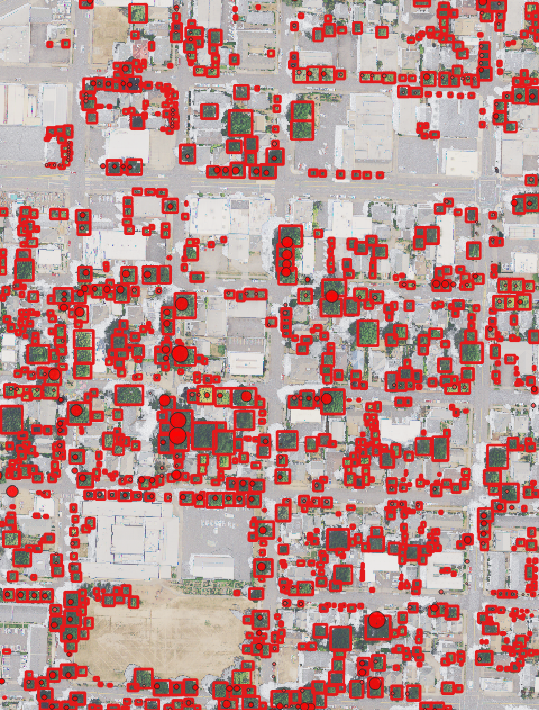

Using the street trees dataset (sized by DBH in yellow), I hand annotated visible crowns in a small section of data that did not overlap with the evaluation area. The next steps are to read in the shapefile creating in QGIS with the bounding box coordinates and divide the training tile into 400px windows to train the model

## Format training annotations

In [15]:
#convert hand annotations from shp into DeepForest format
train_rgb = "/Users/ben/Dropbox/Weecology/DeepForest/Oregon/street_trees_train.tif"
annotation = shapefile_to_annotations(shapefile="/Users/ben/Dropbox/Weecology/DeepForest/Oregon/train_projected.shp",
                                      rgb=train_rgb)

#make sure all annotations are valid.

#Write converted dataframe to file. Saved alongside the images
crop_dir = "/Users/ben/Dropbox/Weecology/DeepForest/Oregon/crops/"
annotation.to_csv(crop_dir + "train_example.csv", index=False)

#Find data on path
train_annotations= preprocess.split_raster(path_to_raster=train_rgb,
                                 annotations_file= crop_dir + "train_example.csv",
                                 base_dir=crop_dir,
                                 patch_size=400,
                                 patch_overlap=0.05)
#View output
train_annotations.head()

#Write window annotations file without a header row, same location as the "base_dir" above.
annotations_file= os.path.join(crop_dir, "train_example.csv")
train_annotations.to_csv(annotations_file,index=False, header=None)

## Train Model

In [16]:
# Example run with short training
trained_model = deepforest.deepforest()
trained_model.use_release()

# Example run with short training
trained_model.config["epochs"] = 3
trained_model.config["save-snapshot"] = False
trained_model.train(annotations=annotations_file, input_type="fit_generator")

Reading config file: /Users/ben/Documents/DeepForest_demos/env/lib/python3.7/site-packages/deepforest/data/deepforest_config.yml
A blank deepforest object created. To perform prediction, either train or load an existing model.
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/v0.2.1 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/v0.2.1
tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors
There are 1 unique labels: ['Tree'] 
Disabling snapshot saving
Training retinanet with the following args ['--weights', '/Users/ben/Documents/DeepForest_demos/env/lib/python3.7/site-pa

Epoch 1/3
20/20 [==============================] - 155s 8s/step - loss: 1.9309 - regression_loss: 1.6241 - classification_loss: 0.3068
Epoch 2/3
20/20 [==============================] - 149s 7s/step - loss: 1.7670 - regression_loss: 1.5187 - classification_loss: 0.2482
Epoch 3/3
20/20 [==============================] - 157s 8s/step - loss: 1.6768 - regression_loss: 1.4478 - classification_loss: 0.2290


In [29]:
## Predict test data with trained model
trained_model.config["score_threshold"] = 0.15
trained_prediction = trained_model.predict_tile(raster_path, patch_size=400,patch_overlap=0.1)
trained_boxes = project(raster_path,trained_prediction)
trained_boxes.to_file("/Users/ben/Dropbox/Weecology/DeepForest/Oregon/trained_model.shp",driver="ESRI Shapefile",crs_wkt=trained_boxes.crs)

5027 predictions in overlapping windows, applying non-max supression
3955 predictions kept after non-max suppression


In [1]:
trained_prediction.score

NameError: name 'trained_prediction' is not defined

In [18]:
### Evaluate trained model predictions

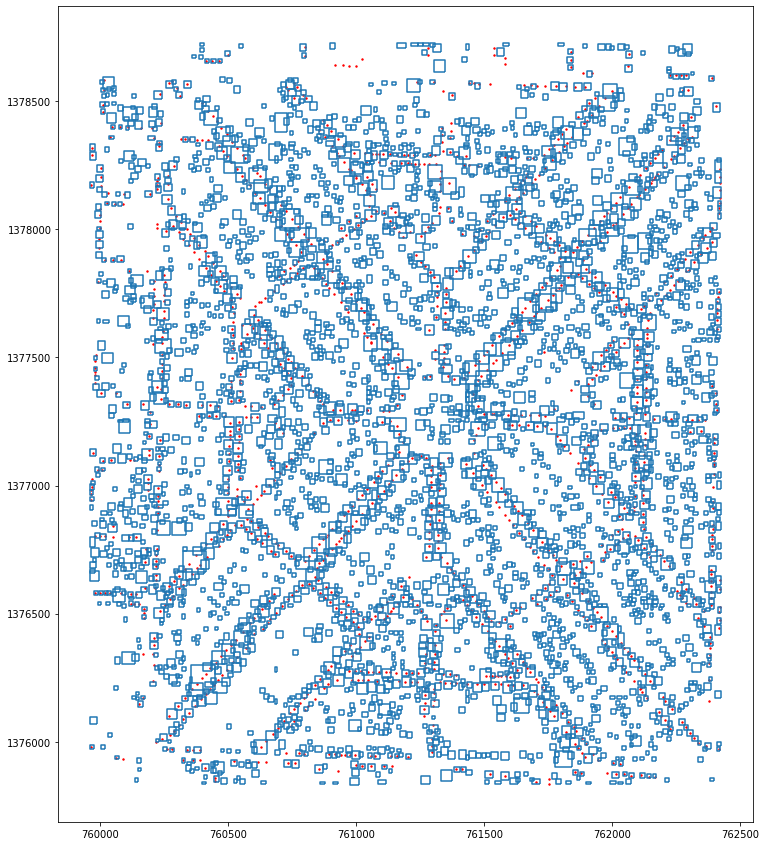

In [19]:
fig,ax = plt.subplots(figsize=(15,15))
trained_boxes.boundary.plot(ax=ax)
test_trees.plot(ax=ax,color="red",markersize=2)

In [20]:
print("Proportion of overlapping predictions: {}".format(sum(trained_boxes.intersects(test_trees.unary_union))/test_trees.shape[0]))
# Could undersegmentations, the number of predictions that overlap with more than one tree
joined_df = geopandas.sjoin(trained_boxes,test_trees)
counts = joined_df.index.value_counts()
print("Proportion of matches that contain more than one ground truth: {}".format(counts[counts>1].shape[0]/len(counts.index.unique())))

Proportion of overlapping predictions: 0.7047440699126092


/Users/ben/Documents/DeepForest_demos/env/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=399999.9999999999 +y_0=0 +ellps=GRS80 +units=ft +no_defs != {'proj': 'lcc', 'lat_1': 43, 'lat_2': 45.5, 'lat_0': 41.75, 'lon_0': -120.5, 'x_0': 399999.9999999999, 'y_0': 0, 'ellps': 'GRS80', 'units': 'ft', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


Proportion of matches that contain more than one ground truth: 0.16474756421612047


In [21]:
joined_df.DBH

0       22.1
0       20.5
2        1.7
3       11.2
7        4.5
        ... 
3766     4.0
3776    11.8
3800    31.0
3815     4.7
3891     8.8
Name: DBH, Length: 1363, dtype: float64

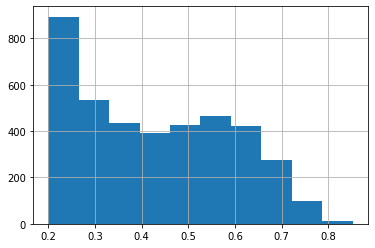

In [22]:
trained_boxes.score.hist()

{'batch_size': 1,
 'weights': '/Users/ben/Documents/DeepForest_demos/env/lib/python3.7/site-packages/deepforest/data/NEON.h5',
 'backbone': 'resnet50',
 'image-min-side': 800,
 'multi-gpu': 1,
 'epochs': 3,
 'validation_annotations': 'None',
 'freeze_layers': 0,
 'freeze_resnet': False,
 'score_threshold': 0.05,
 'multiprocessing': False,
 'workers': 1,
 'max_queue_size': 10,
 'random_transform': False,
 'save-snapshot': False,
 'save_path': 'snapshots/',
 'snapshot_path': 'snapshots/'}